In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [22]:
ailabor_root = '/Users/sidsatya/dev/ailabor'

oes_data_harmonized = pd.read_csv(os.path.join(ailabor_root, 'bls_transformations/output_data1/oes_data_filtered_soc_2018.csv'))
onet_data_harmonized = pd.read_csv(os.path.join(ailabor_root, 'onet_transformations/output_data/task_statements_harmonized_with_attributes.csv'))
classified_tasks = pd.read_csv(os.path.join(ailabor_root, 'task_classification/data/classified_tasks_16_dim.csv'))

/var/folders/y2/820f0d093ps3xgsy472nf3zc0000gn/T/ipykernel_8998/3168405726.py:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  oes_data_harmonized = pd.read_csv(os.path.join(ailabor_root, 'bls_transformations/output_data1/oes_data_filtered_soc_2018.csv'))


In [23]:
onet_soc_list = onet_data_harmonized['O*NET 2018 SOC Code'].unique()

In [24]:
onet_data_with_labels = pd.merge(onet_data_harmonized, classified_tasks, on='Task', how='left')
# count nonempty labels
onet_data_occ_year_grp = onet_data_with_labels.groupby(['O*NET 2018 SOC Code', 'ONET_release_year']).agg({
    'Task': 'count',
    'gpt_label': lambda x: x.notnull().sum(),
    'task_intensity': lambda x: x.notnull().sum()
}).reset_index()

# have to figure out how to handles tasks with nan intensity. 
onet_data_occ_year_grp['valid_occ'] = onet_data_occ_year_grp.apply(lambda x: x['Task'] == x['gpt_label'], axis=1)
onet_data_occ_year_grp

,O*NET 2018 SOC Code,ONET_release_year,Task,gpt_label,task_intensity,valid_occ
0,11-1011,2003,114,114,0,True
1,11-1011,2004,210,210,0,True
2,11-1011,2005,210,210,0,True
3,11-1011,2006,96,96,84,True
4,11-1011,2007,96,96,84,True
...,...,...,...,...,...,...
17553,53-7199,2015,48,48,48,True
17554,53-7199,2016,48,48,48,True
17555,53-7199,2017,48,48,48,True
17556,53-7199,2018,48,48,48,True


In [25]:
valid_onet_soc_list = onet_data_occ_year_grp[onet_data_occ_year_grp['valid_occ']]['O*NET 2018 SOC Code'].unique()

# Add has_valid_onet column first
oes_data_harmonized = oes_data_harmonized.assign(
    has_valid_onet=oes_data_harmonized['soc_2018'].astype(str).isin(valid_onet_soc_list)
)

# Now group and aggregate using the new column
cov = (
    oes_data_harmonized
    .groupby('bls_release_year')
    .agg(emp_missing_onet=('pct_year_tot_emp', lambda s: s[oes_data_harmonized.loc[s.index, 'has_valid_onet'] == False].sum()))
)

cov

,emp_missing_onet
bls_release_year,
2003,0.075264
2004,0.088789
2005,0.088787
2006,0.088394
2007,0.087713
2008,0.086488
2009,0.085535
2010,0.075453
2011,0.075161


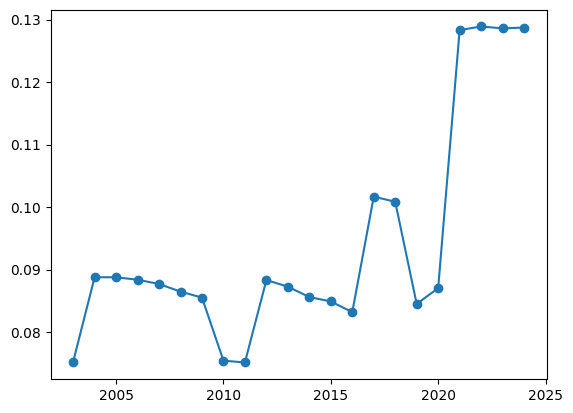

In [26]:
plt.plot(cov.index, cov['emp_missing_onet'], marker='o')

In [27]:
# list top 15 missing occupations in the spike years
for yr in [2010, 2020]:
    miss = (oes_data_harmonized.query('bls_release_year==@yr & ~has_valid_onet')
            .nlargest(15,'pct_year_tot_emp')[['soc_2018','pct_year_tot_emp']])
    print(f'---- missing in {yr} ----')
    print(miss.to_string(index=False))

---- missing in 2010 ----
soc_2018  pct_year_tot_emp
 43-5052          0.002595
 43-5053          0.001163
 41-3031          0.001001
 25-1199          0.000944
 51-3022          0.000898
 47-4051          0.000818
 47-2181          0.000730
 51-3021          0.000715
 53-2031          0.000691
 43-4199          0.000684
 51-3023          0.000666
 49-3093          0.000584
 41-2022          0.000558
 41-3031          0.000557
 43-5051          0.000533
---- missing in 2020 ----
soc_2018  pct_year_tot_emp
 43-5052          0.002438
 41-3031          0.001436
 51-2099          0.001393
 41-3031          0.001287
 25-1199          0.001050
 47-2181          0.000866
 51-3021          0.000848
 41-2022          0.000842
 25-3099          0.000822
 53-2031          0.000822
 51-2099          0.000811
 51-3022          0.000802
 51-2099          0.000796
 51-2099          0.000767
 43-5053          0.000764


In [29]:
onet_data_with_labels[(onet_data_with_labels['O*NET 2018 SOC Code'] == '43-5052')]

,O*NET-SOC Code,O*NET 2010 SOC Code,O*NET 2018 SOC Code,ONET_release_year,Task ID,Task,Task Type,Incumbents Responding,Date,Domain Source,...,normalized_importance,normalized_importance_core,normalized_frequency,normalized_frequency_core,task_intensity,task_intensity_core,first_seen,last_seen,gpt_label,sample_num
30783,43-5052.00,43-5052.00,43-5052,2003,NaN,Bundle mail in preparation for delivery or tra...,NaN,NaN,3/2003,Analyst,...,NaN,NaN,NaN,NaN,NaN,NaN,2003.0,2025.0,NaN,NaN
30784,43-5052.00,43-5052.00,43-5052,2003,NaN,Deliver mail to residences and business establ...,NaN,NaN,3/2003,Analyst,...,NaN,NaN,NaN,NaN,NaN,NaN,2003.0,2025.0,NaN,NaN
30785,43-5052.00,43-5052.00,43-5052,2003,NaN,Enter change of address orders into computers ...,NaN,NaN,3/2003,Analyst,...,NaN,NaN,NaN,NaN,NaN,NaN,2003.0,2023.0,NaN,NaN
30786,43-5052.00,43-5052.00,43-5052,2003,NaN,Hold mail for customers who are away from deli...,NaN,NaN,3/2003,Analyst,...,NaN,NaN,NaN,NaN,NaN,NaN,2003.0,2025.0,NaN,NaN
30787,43-5052.00,43-5052.00,43-5052,2003,NaN,Leave notices telling patrons where to collect...,NaN,NaN,3/2003,Analyst,...,NaN,NaN,NaN,NaN,NaN,NaN,2003.0,2025.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1344909,43-5052.00,43-5052.00,43-5052,2025,11356.0,Report any unusual circumstances concerning ma...,Core,108.0,07/2016,Incumbent,...,0.036439,0.044484,0.028645,0.034059,0.021549,0.025356,2003.0,2025.0,NaN,NaN
1344910,43-5052.00,43-5052.00,43-5052,2025,11357.0,"Register, certify, and insure parcels and lett...",Supplemental,109.0,07/2016,Incumbent,...,0.050903,NaN,0.047669,NaN,0.050096,NaN,2003.0,2025.0,NaN,NaN
1344911,43-5052.00,43-5052.00,43-5052,2025,11358.0,Travel to post offices to pick up the mail for...,Supplemental,108.0,07/2016,Incumbent,...,0.046306,NaN,0.043193,NaN,0.041293,NaN,2003.0,2025.0,NaN,NaN
1344912,43-5052.00,43-5052.00,43-5052,2025,11361.0,Sell stamps and money orders.,Supplemental,109.0,07/2016,Incumbent,...,0.043054,NaN,0.032566,NaN,0.028947,NaN,2003.0,2025.0,NaN,NaN


In [10]:
task_ratings = pd.read_csv(os.path.join(ailabor_root,'onet_transformations/output_data/task_ratings_harmonized.csv'))
task_ratings[task_ratings['O*NET-SOC Code'] == '29-1141.00']['year'].unique()

array([2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021,
       2022, 2023, 2024, 2025])

In [33]:
oes_data = pd.read_csv(os.path.join(ailabor_root, 'bls_transformations/output_data/oes_healthcare_not_in_task_data.csv'))

In [35]:
oes_data.groupby(['soc_2018', 'bls_release_year']).agg('count').reset_index()['soc_2018'].unique()

array(['11-3040', '13-1020', '13-2020', '17-3019', '19-1099', '21-1018',
       '21-1019', '21-1029', '21-1099', '21-2099', '23-2099', '25-1069',
       '25-1199', '25-2052', '25-3097', '25-3098', '25-3099', '25-9045',
       '25-9099', '27-1029', '27-2099', '27-4099', '29-1020', '29-1029',
       '29-2010', '29-9010', '31-1120', '33-1099', '35-2019', '35-9099',
       '37-2019', '37-3019', '39-3099', '39-7010', '39-9099', '41-9099',
       '43-3099', '43-4199', '43-9199', '47-3019', '47-4090', '49-9069',
       '51-2028', '51-2090', '51-2098', '51-2099', '51-3099', '51-6099',
       '51-7099', '51-9199', '53-1047', '53-1048', '53-3099', '53-6099'],
      dtype=object)

In [ ]:
oes_data_aggregated_occ = oes_data[oes_data['is_healthcare_obs']].groupby(['soc_2018', 'bls_release_year']).agg({'tot_emp': 'sum', 'pct_healthcare_tot_emp': ['sum', 'mean']}).reset_index()

In [41]:
oes_data[oes_data['soc_2018'] == '53-6099']

,naics,soc_2018,bls_release_year,tot_emp,pct_year_tot_emp,pct_naics_year_tot_emp,h_mean,a_mean,h_pct10,h_pct25,...,h_pct90,a_pct10,a_pct25,a_median,a_pct75,a_pct90,naics_year_tot_emp,year_tot_emp,pct_healthcare_tot_emp,is_healthcare_obs
1191,621900,53-6099,2004,100.0,8.015686e-07,0.000519,12.12,25210.0,8.95,9.54,...,17.08,18620.0,19840.0,21890.0,27250.0,35530.0,192820.0,124755390.0,0.000007,True
1192,621900,53-6099,2005,110.0,8.655844e-07,0.000551,14.42,29990.0,9.35,10.09,...,25.66,19440.0,20980.0,24170.0,34880.0,53370.0,199700.0,127081780.0,0.000007,True
1193,621900,53-6099,2006,130.0,1.011238e-06,0.000626,17.00,35360.0,9.58,10.36,...,27.41,19930.0,21560.0,25860.0,49640.0,57010.0,207550.0,128555340.0,0.000008,True
1194,621900,53-6099,2016,70.0,5.055944e-07,0.000245,19.05,39630.0,12.31,14.46,...,28.99,25600.0,30070.0,36010.0,53660.0,60290.0,285390.0,138450890.0,0.000004,True
1195,621900,53-6099,2017,90.0,6.402226e-07,0.000305,19.42,40390.0,12.74,15.01,...,29.74,26510.0,31210.0,36850.0,54450.0,61870.0,294840.0,140576110.0,0.000004,True
1196,621900,53-6099,2019,100.0,6.958378e-07,0.000327,17.07,35510.0,9.24,10.57,...,35.32,19220.0,21980.0,25520.0,37240.0,73470.0,305430.0,143711660.0,0.000005,True
1197,621900,53-6099,2020,110.0,8.040578e-07,0.000361,17.47,36340.0,10.01,11.04,...,36.35,20820.0,22960.0,26400.0,34960.0,75610.0,304360.0,136806090.0,0.000005,True
1646,622100,53-6099,2004,200.0,1.603137e-06,0.000042,12.15,25260.0,7.36,8.40,...,20.87,15310.0,17460.0,21170.0,33520.0,43400.0,4748380.0,124755390.0,0.000014,True
1647,622100,53-6099,2005,100.0,7.868949e-07,0.000021,13.35,27770.0,7.83,9.04,...,22.10,16280.0,18800.0,22420.0,36420.0,45970.0,4815590.0,127081780.0,0.000007,True
1648,622100,53-6099,2006,80.0,6.223001e-07,0.000016,14.42,30000.0,8.06,9.76,...,24.44,16770.0,20310.0,24040.0,40720.0,50830.0,4879290.0,128555340.0,0.000005,True
